# import library


In [1]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_minimum, threshold_mean, rank, gaussian, sobel
from skimage.feature import canny
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage.morphology import rectangle
from skimage import measure
import numpy as np
import cv2

# load image


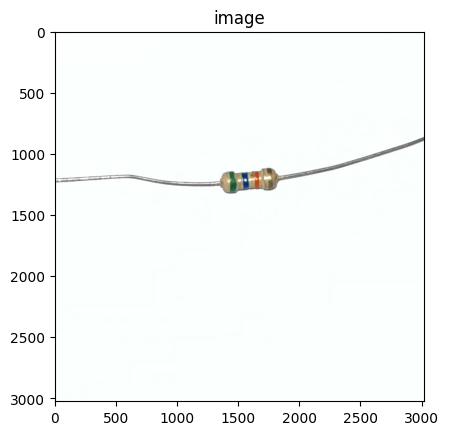

In [2]:
# image = cv2.imread(r"img\3.9k\IMG_0525.JPG")
# image = cv2.flip(image, 1)

# image = cv2.imread(r"img\10k\IMG_0581.JPG")
# image = cv2.imread(r"res.jpg")
image = cv2.imread(r"img\56k\IMG_0550.JPG")
# image = cv2.imread(r"img\270k\IMG_0619.JPG")

plt.imshow(image[:,:,::-1])
plt.title("image")
plt.show()


# Step 1: Crop Resister


## 1.1 threshold segmentation


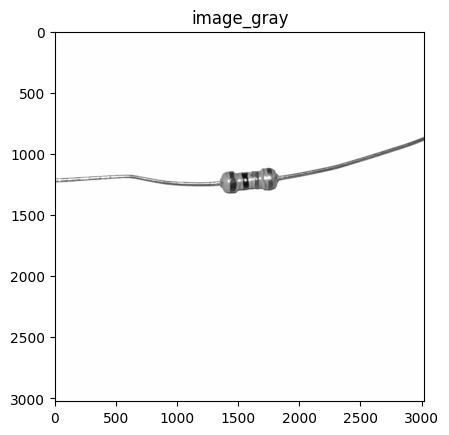

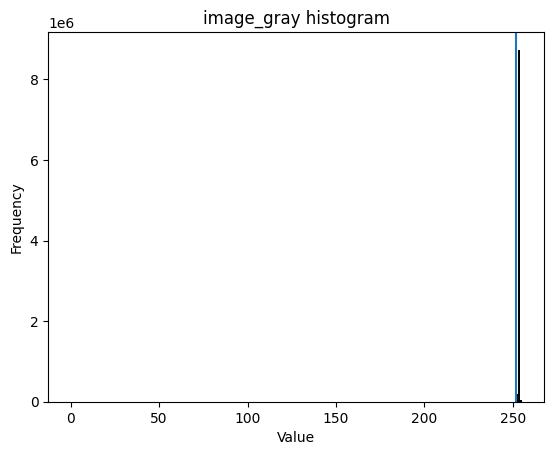

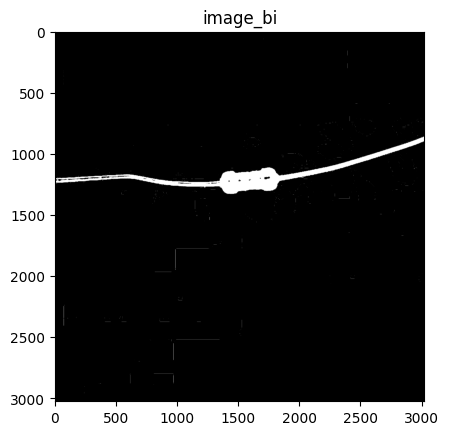

In [3]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Binomal histrogram / threshold segmentation
image_mean = threshold_mean(image_gray)
image_bi = image_gray < image_mean
image_bi = image_bi.astype(np.uint8) * 255

plt.imshow(image_gray, cmap="gray")
plt.title("image_gray")
plt.show()


plt.hist(image_gray.ravel(), bins=256, range=(0, 255), color='black')
plt.axvline(image_mean)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("image_gray histogram")
plt.show()


plt.imshow(image_bi, cmap="gray")
plt.title("image_bi")
plt.show()
plt.show()

## 1.2 Morphological Image Processing


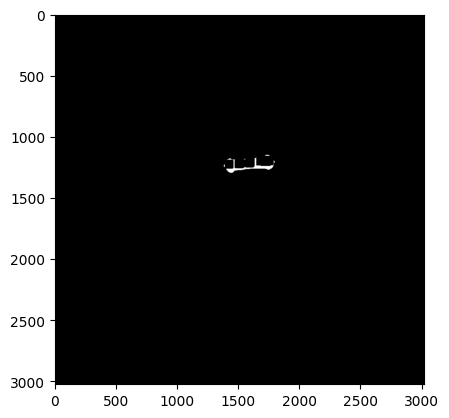

In [4]:
# Morphological Image Processing
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
image_mor = cv2.erode(image_bi, kernel, iterations = 15)
plt.imshow(image_mor, cmap="gray")
plt.show()

## 1.3 find boarder of resistor


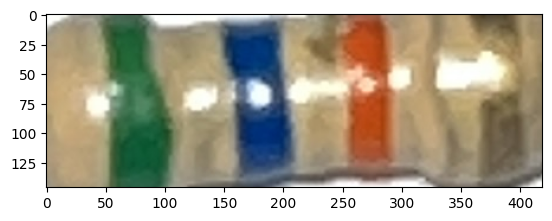

In [5]:

# find image boarder
xStart, xEnd, yStart, yEnd = image_mor.shape[0],0,image_mor.shape[1],0

for r in range(image_mor.shape[0]):
    for c in range(image_mor.shape[1]):
        if image_mor[r][c]:
            if xStart > r:
                xStart = r
            
            if yStart > c:
                yStart = c
            
            if r > xEnd: xEnd = r
            if c > yEnd: yEnd = c

image_crop = image[xStart:xEnd, yStart: yEnd]
plt.imshow(image_crop[:,:,::-1], cmap="gray")
plt.show()

# Step 2: Extract the color


## 2.1 Seperate 2 areas that have no reflected light


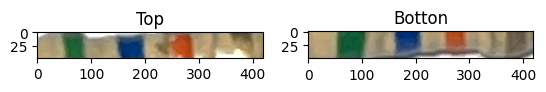

In [6]:

image_gray = cv2.cvtColor(image_crop.astype(image.dtype), cv2.COLOR_BGR2GRAY)

# quartile seperation
yQ1 = image_gray.shape[0] // 3 * 1 # top
yQ2 = image_gray.shape[0] // 3 * 2  # bottom

imageTopCrop = image_crop[:yQ1,:]
imageBottomCrop = image_crop[yQ2:,:]

plt.subplot(121)
plt.imshow(imageTopCrop[:,:,::-1])
plt.title("Top")

plt.subplot(122)
plt.imshow(imageBottomCrop[:,:,::-1])
plt.title("Botton")

plt.show()

## 2.2 threshold segmentation


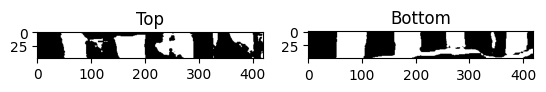

In [7]:
# Binomal histrogram / threshold segmentation
imageTopGray = cv2.cvtColor(imageTopCrop, cv2.COLOR_BGR2GRAY)
imageTopMean = threshold_mean(imageTopGray)
imageTopBi = imageTopGray < imageTopMean
imageTopBi = imageTopBi.astype(np.uint8) * 255

imageBottomGray = cv2.cvtColor(imageBottomCrop, cv2.COLOR_BGR2GRAY)
imageBottomMean = threshold_mean(imageBottomGray)
imageBottomBi = imageBottomGray < imageBottomMean
imageBottomBi = imageBottomBi.astype(np.uint8) * 255

# binary image
plt.subplot(121)
plt.imshow(imageTopBi, cmap="gray")
plt.title("Top")

plt.subplot(122)
plt.imshow(imageBottomBi, cmap="gray")
plt.title("Bottom")

plt.show()

### 2.2.1 image histogram

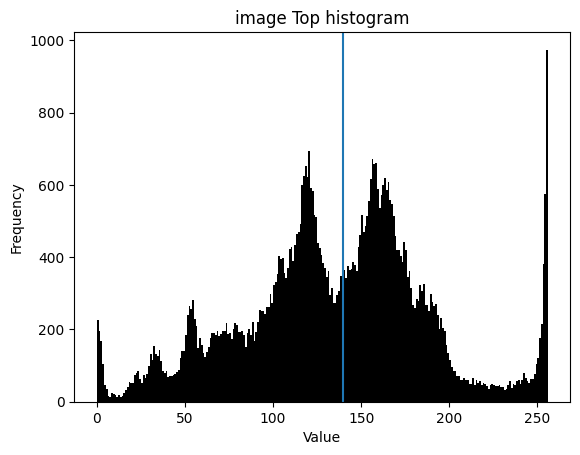

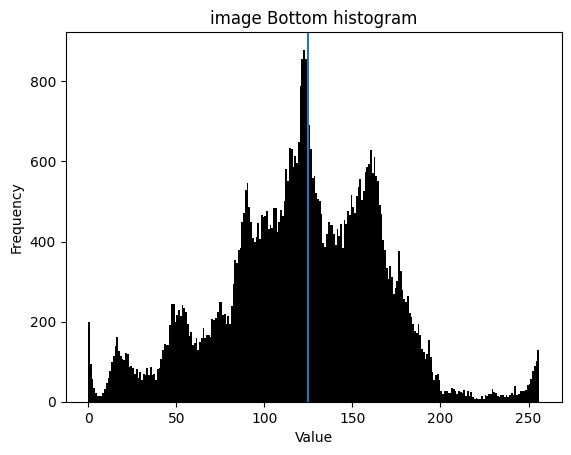

In [8]:
# threshold segmentation and histogram
plt.hist(imageTopCrop.ravel(), bins=256, range=(0, 256), color='black')
plt.axvline(imageTopMean)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("image Top histogram")
plt.show()


plt.hist(imageBottomCrop.ravel(), bins=256, range=(0, 256), color='black')
plt.axvline(imageBottomMean)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("image Bottom histogram")
plt.show()

## 2.3 Morphological Image Processing


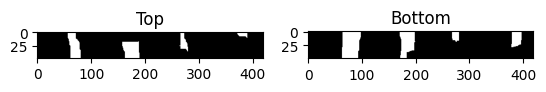

In [9]:
# Erosion
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
imageTopMor = cv2.erode(imageTopBi, kernel, iterations = 5)

# Erosion
imageBottomMor = cv2.erode(imageBottomBi, kernel, iterations = 5)

plt.subplot(121)
plt.imshow(imageTopMor, cmap="gray")
plt.title("Top")

plt.subplot(122)
plt.imshow(imageBottomMor, cmap="gray")
plt.title("Bottom")

plt.show()

## 2.4 Extract color segment 

Band 1:
 - X range: 63 → 98
 - Y range: 0 → 50

Band 2:
 - X range: 170 → 199
 - Y range: 0 → 50

Band 3:
 - X range: 267 → 280
 - Y range: 0 → 20

Band 4:
 - X range: 377 → 396
 - Y range: 0 → 30



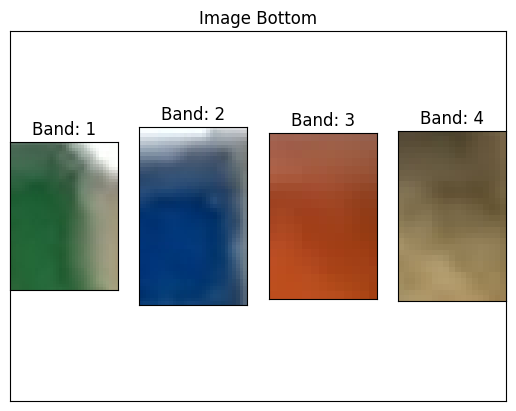

In [10]:
def extractColor(image):
    arr = []
    
    # Label connected components
    labels = measure.label(image.astype(np.bool))

    # Measure regions
    regions = measure.regionprops(labels)
    # print(regions[0].bbox)
    # Extract x,y ranges for each segment
    for i, region in enumerate(regions, start=1):
        min_row, min_col, max_row, max_col = region.bbox

        # Note: rows = Y, cols = X in image coordinates
        y_min, y_max = min_row, max_row
        x_min, x_max = min_col, max_col

        print(f"Band {i}:")
        print(f" - X range: {x_min} → {x_max}")
        print(f" - Y range: {y_min} → {y_max}")
        print()
        arr.append(
            {
                "x_min": x_min,
                "x_max": x_max,
                "y_min": y_min,
                "y_max": y_max,
            }
        )
        
    return arr

# TopSeg = extractColor(imageTopMor)  # CONTAIN COLOR SEGMENT OF IMAGE TOP

# band_images = []
# for v in TopSeg:
#     temp = imageTopCrop[v["y_min"]:v["y_max"],
#                         v["x_min"]:v["x_max"]]
#     band_images.append(temp)
    
# plt.title("Image Top")
# plt.xticks([])
# plt.yticks([])

# for i, v in enumerate(TopSeg):
#     plt.subplot(1, len(TopSeg), i+1)
#     temp = imageTopCrop[v["y_min"]:v["y_max"],
#                         v["x_min"]:v["x_max"]]
#     plt.imshow(temp[:,:,::-1])
#     plt.title(f"Band: {i+1}")
#     plt.xticks([])
#     plt.yticks([])

# plt.show()

BottomSeg = extractColor(imageBottomMor)  # CONTAIN COLOR SEGMENT OF IMAGE BOTTOM

band_images = []
for v in BottomSeg:
    temp = imageTopCrop[v["y_min"]:v["y_max"],
                        v["x_min"]:v["x_max"]]
    band_images.append(temp)
    
plt.title("Image Bottom")
plt.xticks([])
plt.yticks([])

for i, v in enumerate(BottomSeg):
    plt.subplot(1, len(BottomSeg), i+1)
    temp = imageTopCrop[v["y_min"]:v["y_max"],
                        v["x_min"]:v["x_max"]]
    plt.imshow(temp[:,:,::-1])
    plt.title(f"Band: {i+1}")
    plt.xticks([])
    plt.yticks([])

plt.show()

# Step 3: Band Color Code Calculation
## 3.1 Set the range of color in HSV

In [11]:
# =================== ตารางสีตัวต้านทาน HSV (range) ===================
resistor_colors_hsv_range = {
    "Black":   ((0,180), (0, 80), (0,90)),
    "Brown":   ((0, 20), (90,255), (50,150)),
    "Red":     ((0, 8), (150,255), (100,255)),
    "Red":    ((170,180), (150,255), (100,255)),
    "Orange":  ((8, 25), (150,255), (130,255)),
    "Yellow":  ((25, 40), (150,255), (150,255)),
    "Green":   ((40, 85), (100,255), (50,255)),
    "Blue":    ((85,140), (100,255), (50,255)),
    "Violet":  ((140,170), (100,255), (50,255)),
    "Gray":    ((0,180), (0, 50), (100,200)),
    "White":   ((0,180), (0, 30), (200,255)),
    "Gold":    ((15, 35), (50,200), (100,200)),
    "Silver":  ((0,180), (0, 50), (150,220)),
}

## 3.2 Find the color

In [12]:
# =================== ฟังก์ชันหาสีที่ใกล้ที่สุด ===================
def closest_color_hsv(hsv_val):
    h, s, v = hsv_val
    for name, ((hmin,hmax),(smin,smax),(vmin,vmax)) in resistor_colors_hsv_range.items():
        if hmin <= h <= hmax and smin <= s <= smax and vmin <= v <= vmax:
            return name
    return "Unknown"

## 3.3 Elaborate the color

In [13]:
# =================== ฟังก์ชัน crop แถบสี ===================
def get_central_median_hsv(image, crop_ratio=0.5):
    """
    crop_ratio: สัดส่วนกลางของแถบที่จะเอามาวิเคราะห์ (0-1)
    """
    h, w = image.shape[:2]
    h_crop = int(h * crop_ratio)
    w_crop = int(w * crop_ratio)
    h_start = (h - h_crop)//2
    w_start = (w - w_crop)//2
    central_crop = image[h_start:h_start+h_crop, w_start:w_start+w_crop]
    
    hsv = cv2.cvtColor(central_crop, cv2.COLOR_BGR2HSV)
    h_med = int(np.median(hsv[:,:,0]))
    s_med = int(np.median(hsv[:,:,1]))
    v_med = int(np.median(hsv[:,:,2]))
    return (h_med, s_med, v_med)

In [14]:
# =================== อ่านสีจาก band ===================
band_colors = {}
for idx, band_img in enumerate(band_images):
    hsv_val = get_central_median_hsv(band_img, crop_ratio=0.5)
    color_name = closest_color_hsv(hsv_val)
    band_colors[f'Band {idx+1}'] = (hsv_val, color_name)

In [15]:
# =================== แสดงผล ===================
for band, (hsv_val, name) in band_colors.items():
    print(f'{band}: HSV = {hsv_val}, Color = {name}')

Band 1: HSV = (68, 140, 97), Color = Green
Band 2: HSV = (106, 249, 115), Color = Blue
Band 3: HSV = (8, 207, 161), Color = Orange
Band 4: HSV = (20, 107, 120), Color = Brown


## 3.4 Set the band color code

In [16]:
# =================== ตารางสี → ตัวเลข / multiplier / tolerance ===================
resistor_color_digit = {
    "Black": 0, "Brown": 1, "Red": 2, "Orange": 3, "Yellow": 4,
    "Green": 5, "Blue": 6, "Violet": 7, "Gray": 8, "White": 9
}

resistor_color_multiplier = {
    "Black": 1, "Brown": 10, "Red": 100, "Orange": 1_000, "Yellow": 10_000,
    "Green": 100_000, "Blue": 1_000_000, "Violet": 10_000_000,
    "Gold": 0.1, "Silver": 0.01
}

resistor_color_tolerance = {
    "Brown": "±1%", "Red": "±2%", "Green": "±0.5%", "Blue": "±0.25%",
    "Violet": "±0.1%", "Gray": "±0.05%", "Gold": "±5%", "Silver": "±10%"
}

## 3.5 Result

In [17]:
# =================== เลือกชื่อสีจาก band_colors ===================
# band_colors = {'Band 1': (...,'Red'), 'Band 3': (...,'Green'), ...}
color_names = [
    band_colors.get('Band 1', ('','Unknown'))[1],
    band_colors.get('Band 2', ('','Unknown'))[1],
    band_colors.get('Band 3', ('','Unknown'))[1],
    # band_colors.get('Band 4', ('','Unknown'))[1]
]

In [18]:
# ตรวจสอบว่าอ่านสีได้ทั้งหมด
if "Unknown" in color_names:
    print("มี band ที่ไม่สามารถอ่านสีได้!")
else:
    # คำนวณค่า resistor 5-band
    digit1 = resistor_color_digit[color_names[0]]
    digit2 = resistor_color_digit[color_names[1]]
    multiplier = resistor_color_multiplier[color_names[2]]
    # tolerance = resistor_color_tolerance.get(color_names[3], "±20%")
    

    resistance_value = (digit1*10 + digit2*1) * multiplier

    # แสดงผล
    if resistance_value >= 1_000_000:
        print(f"Resistance: {resistance_value/1_000_000} MΩ")
    elif resistance_value >= 1_000:
        print(f"Resistance: {resistance_value/1_000} kΩ")
    else:
        print(f"Resistance: {resistance_value} Ω")


Resistance: 56.0 kΩ
